In [ ]:
import numpy as np
import pandas as pd
import csv

## Cleanup

In [ ]:
yelp_df = pd.read_csv('/home/gavagai/all_reviews.csv')
to_drop = yelp_df.query('label != "remote" and label != "local"').index
yelp_df = yelp_df.drop(to_drop)
yelp_df.reindex()

## Import

In [ ]:
yelp_df = pd.read_csv('/home/gavagai/all_reviews_cleaned.csv')
#yelp_df = yelp_df.drop('Unnamed: 0', axis=1)
#yelp_df = yelp_df.drop_duplicates()
#yelp_df = yelp_df.reset_index(drop=True)

In [13]:
yelp_df.groupby('label').agg('mean')

,business_star_rating,business_zip,cool,funny,review_raiting,useful
label,,,,,,
local,3.856649,58714.462936,3.432714,2.656943,3.880876,3.578655
remote,3.804895,50765.636406,3.777087,3.156139,3.963844,3.651013


### Business data frame

In [5]:
biz_df = yelp_df.iloc[:,0:6].drop_duplicates().astype('object')
biz_df[['business_star_rating']] = biz_df[['business_star_rating']].apply(pd.to_numeric)

In [6]:
biz_df.drop('business_star_rating', axis = 1).describe()

,business_city,business_name,business_state,business_url,business_zip
count,4280,4280,4280,4280,4279.0
unique,104,3807,6,4280,353.0
top,Chicago,Shake Shack,IL,https://www.yelp.com/biz/toast-bakery-cafe-los...,32819.0
freq,905,11,990,1,188.0


In [7]:
biz_df.describe()

,business_star_rating
count,4280.000000
mean,3.840537
std,0.445149
min,2.000000
25%,3.500000
50%,4.000000
75%,4.000000
max,5.000000


In [ ]:
biz_df[['business_star_rating', 'business_url']].groupby('business_star_rating').agg('count')

## General summary

### Categorical

In [ ]:
yelp_df.drop(['business_star_rating','business_zip','review_raiting', 'useful', 'funny', 'cool'], axis=1)

### Numeric

In [ ]:
yelp_df[['business_star_rating', 'review_raiting', 'useful', 'funny', 'cool']].describe()

### Missing

In [ ]:
yelp_df.isna().sum(0)

## Label Anaysis

In [ ]:
yelp_df[['business_url']].groupby([yelp_df['business_state'], yelp_df['label'] ]).agg('count')

In [ ]:
biz_label_group = yelp_df[['business_state','label']].groupby(
    [yelp_df['business_state'], yelp_df['label']])

biz_label_group.agg('count').apply(lambda x: 100 * x / float(x.sum()))

In [ ]:
yelp_df.groupby(yelp_df['label']).agg('count')

In [ ]:
test = yelp_df[['funny', 'label', 'business_url', 'review_text']].sort_values('funny', ascending=False).iloc[0,3]
re.search(r'[ \f\t\v]+$', test)

In [ ]:
import re
yelp_df[['review_text', 'business_url']].assign(end_on_whitespace=yelp_df['review_text'].apply(lambda x: re.search(' +$', x) != None)).query('end_on_whitespace == True')
#re.findall('\s$', yelp_df['review_text'])

In [ ]:
yelp_df.isna().sum(0)

In [ ]:
yelp_df.sort_values('funny', ascending=False).drop_duplicates()

# Fretures

## Length of review

In [ ]:
yelp_df[['review_text', 'label']].assign(review_length =
    yelp_df['review_text'].apply(lambda x: len(x))).query('label == "local"')

In [ ]:
yelp_df[['review_text', 'label']].assign(review_length =
    yelp_df['review_text'].apply(lambda x: len(x))).query('label == "remote"').describe()

#### Ratio of business rating to review rating

In [ ]:
yelp_df[['business_star_rating', 'review_raiting']].assign(review_biz_ratio= (yelp_df['review_raiting']/yelp_df['business_star_rating'])).sort_values('review_biz_ratio')

# Plots

In [15]:
from matplotlib import pyplot as plt

from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk import FreqDist

In [67]:
yelp_df = yelp_df.rename(columns={'cool': 'cool_', 'label': 'label_', 'funny': 'funny_', 'useful': 'useful_'})

state_min = min(yelp_df.query('business_state != "NJ"').groupby('business_state').agg('count').iloc[:, 0 ])

print(state_min)

sample_ny = yelp_df.query('business_state == "NY"').sample(n=state_min)
sample_nv = yelp_df.query('business_state == "NV"').sample(n=state_min)
sample_ca = yelp_df.query('business_state == "CA"').sample(n=state_min)
sample_fl = yelp_df.query('business_state == "FL"').sample(n=state_min)
sample_il = yelp_df.query('business_state == "IL"').sample(n=state_min)

sample = pd.concat([sample_ny, sample_nv, sample_ca, sample_fl, sample_il]).reset_index(drop = True)

sample_min = min(sample.groupby('label_').agg('count').iloc[:, 0])

print(sample_min)

local_sample = sample.query('label_ == "local"').sample(n=sample_min)
remote_sample = sample.query('label_ == "remote"').sample(n=sample_min)

yelp_df = pd.concat([local_sample, remote_sample]).reset_index(drop = True)

6859
16500


In [17]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(yelp_df['review_text'].apply(lambda x: x.lower()))
features   = vectorizer.get_feature_names()

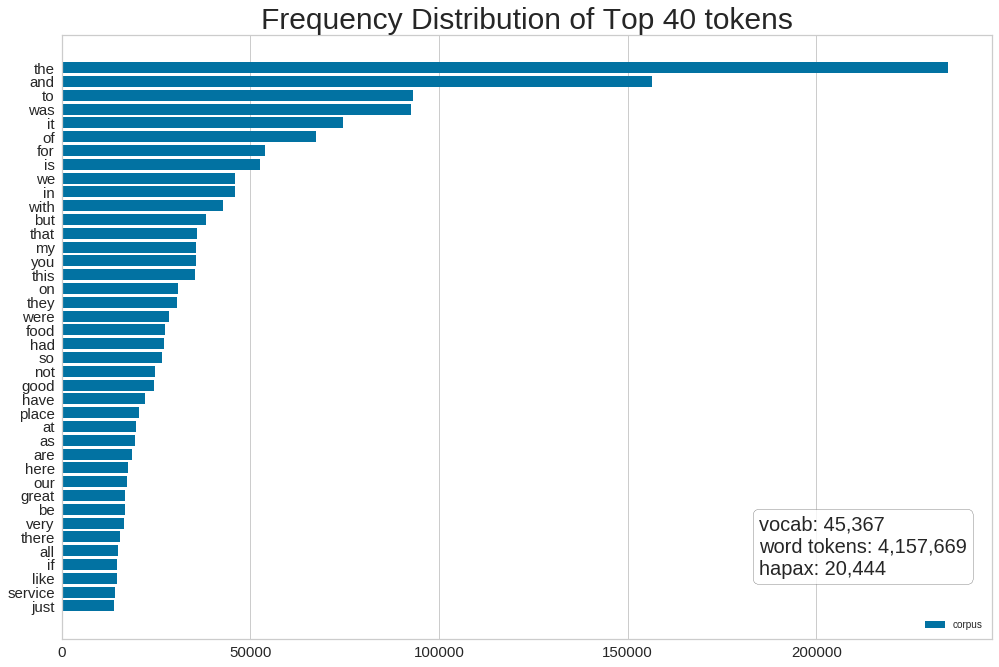

In [18]:
visualizer = FreqDistVisualizer(n= 40, fontsize=25, features=features, orient='h', size=(1200, 800))
visualizer.fit(docs)
visualizer.ax.legend(loc=4)
visualizer.set_title()
# Set the title
# Create the vocab, count, and hapaxes labels
infolabel = "vocab: {:,}\nword tokens: {:,}\nhapax: {:,}".format(
    visualizer.vocab_, visualizer.words_, visualizer.hapaxes_
)

visualizer.ax.text(0.68, 0.97, infolabel, position=(.75,.1), transform=visualizer.ax.transAxes,
             fontsize=20, verticalalignment='bottom',
             bbox={'boxstyle':'round', 'facecolor':'white', 'alpha':.8})

# Set the legend and the grid
plt.title('Frequency Distribution of Top {} tokens'.format(visualizer.N), fontsize=30)
plt.yticks(size=15)
plt.xticks(size=15)
plt.rcParams.update({'font.size': 22})
plt.show(visualizer)


In [24]:
tokenizer = RegexpTokenizer(r'\w+')
corpus_retokenized = tokenizer.tokenize(' '.join(yelp_df['review_text']).lower())

In [25]:
reword_freq = FreqDist(corpus_retokenized)

In [26]:
import operator
refreq = reword_freq
#freq = dict(sorted(freq.items(), reverse=True, key=lambda kv: kv[1]))
refreq = sorted(refreq.items(), reverse=True, key=operator.itemgetter(1))
for i in range(len(refreq)):
    refreq[i] = (i, refreq[i][1])

In [27]:
refreq_df = pd.DataFrame.from_dict(dict(refreq), orient='index')
refreq_df = refreq_df.rename(columns={0: 'frequency'})
refreq_df['count'] = refreq_df.index + 1

Text(0.5,0,'Word Type Rank (by Frequency)')

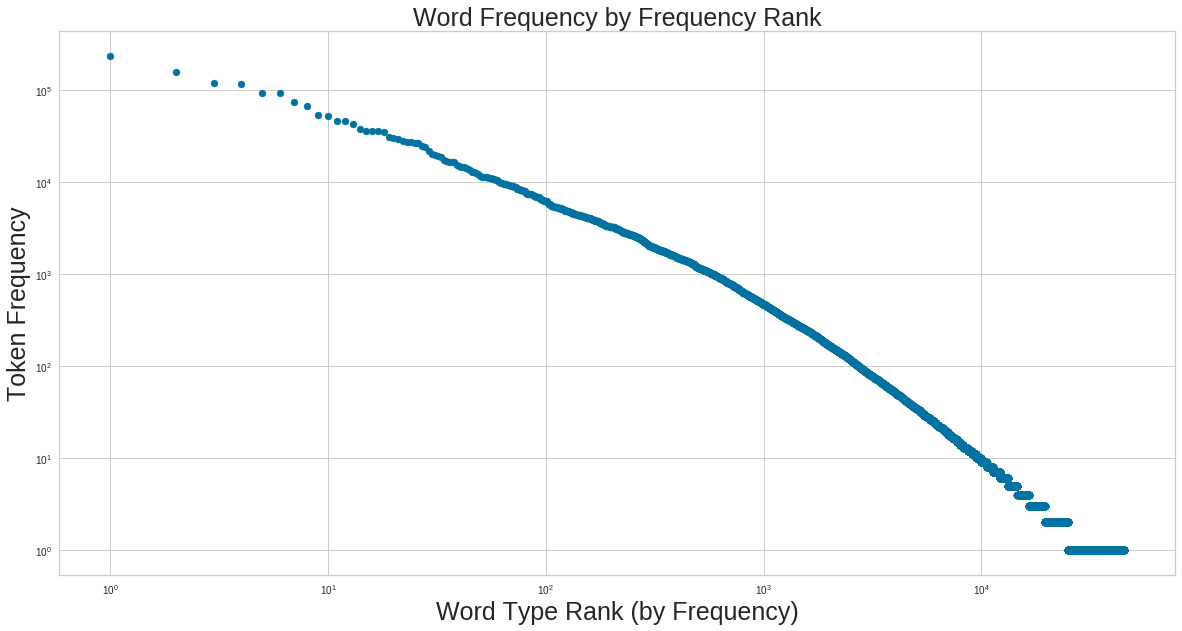

In [28]:
plt.figure(figsize=(20,10))
s = plt.scatter(refreq_df['count'], refreq_df['frequency'])
s.axes.loglog(True)
plt.title('Word Frequency by Frequency Rank', fontsize=25)
plt.ylabel('Token Frequency', fontsize=25)
plt.xlabel('Word Type Rank (by Frequency)', fontsize=25)
#refreq_df.plot(kind='scatter', loglog=True,  x='count', y='frequency')

Zipf's law states natural language corpus of utterances, the frequency of any word type is inversely proportional to its rank in the frequency table.

So frequency of the word with rank n is proportional to 1/n. In other words, the most ranked word is around twice as common as the second ranked word, and a thousand times more common than the word with rank 100,000.)

We can check Zipf's Law for the scraped corpus of Yelp reviews by plotting the frequencies of the word types in rank order on a log-log graph.

## Add confusion matrx

## Add decision Plot

# Modeling

## Import

In [300]:
import numpy as np
import pandas as pd
import pickle
import time
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [301]:
yelp_df = pd.read_csv('/home/gavagai/code/yelp_tourist_classifier/data/all_reviews_cleaned.csv')

## Add features

#### review length

In [302]:
yelp_df= yelp_df.assign(review_length =
    yelp_df['review_text'].apply(lambda x: len(x)))

#### week of year

In [303]:
yelp_df = yelp_df.assign(week_of_year =
    yelp_df['review_date'].apply(lambda x: time.strptime(x, "%m/%d/%Y").tm_yday // 7))

#### day of week

In [304]:
yelp_df = yelp_df.assign(day_of_week =
    yelp_df['review_date'].apply(lambda x: time.strptime(x, "%m/%d/%Y").tm_wday))

#### city mentioned

In [305]:
yelp_df = yelp_df.assign(city_mentioned = 0)

In [306]:
vecIn = np.vectorize(lambda a, b: a.lower() in b.lower() )

In [307]:
yelp_df = yelp_df.assign(city_mentioned = np.where(vecIn(yelp_df['business_city'].values, yelp_df['review_text'].values), 1, 0))

#### reviewer state

In [308]:
yelp_df = yelp_df.assign(reviewer_state = yelp_df['reviewer_location'].astype(str).apply(lambda x: x[-2:]))

#### POS Tagging

In [309]:
from nltk.tag.stanford import StanfordPOSTagger
from nltk import word_tokenize
from os import environ
import pickle
import nltk

def review_tokenize(reviews):
    return map(lambda review: word_tokenize(review), reviews)

def review_tager(tokenized_reviews):    
    st_model_path = r'SPOST/models/english-bidirectional-distsim.tagger'
    st = StanfordPOSTagger(st_model_path,
                           r'SPOST/stanford-postagger.jar')
    results = []
    errors = []
    count = 0

#     return map(lambda review: st.tag(review), tokenized_reviews)
    for review in tokenized_reviews:
        try:
            results.append(st.tag(review))
            count += 1
        except:
            print(count)
            errors.append(count)
            results.append(review)
            count += 1
    print('errors for the following indexes\n', errors)
    return results  # [st.tag(review) for review in tokenized_reviews]


In [ ]:
# tokenized_reviews = review_tokenize(yelp_df['review_text'])
# reviews_tagged = review_tager(tokenized_reviews)

In [92]:
with open('reviews_tagged.p', 'rb') as f_reviews_tagged:
    reviews_tagged = pickle.load(f_reviews_tagged)

In [77]:
pos = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']
{}

for p in pos:
    for review in yelp_df['reviews_tagged']

In [ ]:
def pos(df, pos_, text_field1, text_field2):
    vecIn = np.vectorize(lambda a, b: a.lower() in b.lower())
    return df.assign(pos_=np.where(
        vecIn(df[text_field1].values, df[text_field2].values), 1, 0))

In [57]:
yelp_df['reviews_tagged'] = reviews_tagged

In [310]:
class pos_counter():

    adverbs = [u'RB', u'RBR', u'RBS', u'RBS\r', u'RB\r', u'RBR\r']
    simple_past = [u'VBD', u'VBD\r']
    simple_present = [u'VBP', u'VPZ', u'VBP\r', u'VPZ\r']
    past_participle = [u'VBN', u'VBN\r']
    modal = [u'MD', u'MD\r']
    pn = [u'NNP', u'NNPS', u'NNP\r', u'NNPS\r']
    prep = [u'IN', u'IN\r']
    nn = [u'NN', u'NN\r']
    adj = [u'JJ', u'JJ\r']
    dt = [u'DT', u'DT\r']

    def count_pos(tagged_reviews, pos_list):
        count = 0
        for review in tagged_reviews:
            try:
                if review[1] in pos_list:
                    count += 1
            except:
                pass
        return float(count)

## POS Features

In [311]:
yelp_df["adv count"] = [
        pos_counter.count_pos(review, pos_counter.adverbs)
        for review in reviews_tagged]

yelp_df["past prog"] = [
    pos_counter.count_pos(review, pos_counter.past_participle)
    for review in reviews_tagged]

yelp_df["simple future"] = [
    pos_counter.count_pos(review, pos_counter.modal)
    for review in reviews_tagged]

yelp_df["simple past"] = [
    pos_counter.count_pos(review, pos_counter.simple_past)
    for review in reviews_tagged]

yelp_df["simple present"] = [
    pos_counter.count_pos(review, pos_counter.simple_present)
    for review in reviews_tagged]

yelp_df['porper name'] = [
    pos_counter.count_pos(review, pos_counter.pn)
    for review in reviews_tagged]

yelp_df['prep count'] = [
    pos_counter.count_pos(review, pos_counter.prep)
    for review in reviews_tagged]

yelp_df['nn count'] = [
    pos_counter.count_pos(review, pos_counter.nn)
    for review in reviews_tagged]

yelp_df['adj count'] = [
    pos_counter.count_pos(review, pos_counter.adj)
    for review in reviews_tagged]

yelp_df['det count'] = [
    pos_counter.count_pos(review, pos_counter.dt)
    for review in reviews_tagged]

In [261]:
pltme =yelp_df.loc[:, ['det count', 'adj count', 'nn count', 'prep count', 'porper name', "simple present", "simple past", "simple future", "past prog", 'adv count', 'label']].groupby('label').agg('sum').apply(lambda x: (x[0] - x[1] / x[0] + x[1])).transform(lambda x:((x-x.mean())/x.std()))

In [242]:
pltme = pd.DataFrame(pltme).T

In [299]:
!('/home/gavagai/Screenshots/screenshot_2018-10-31-1541006284.png')


/usr/bin/sh: /home/gavagai/Screenshots/screenshot_2018-10-31-1541006284.png: Permission denied


In [281]:
ticks = ['det count', 'adj count', 'nn count', 'prep count', 'porper name',
       'simple present', 'simple past', 'simple future', 'past prog',
       'adv count']

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 9 Text yticklabel objects>)

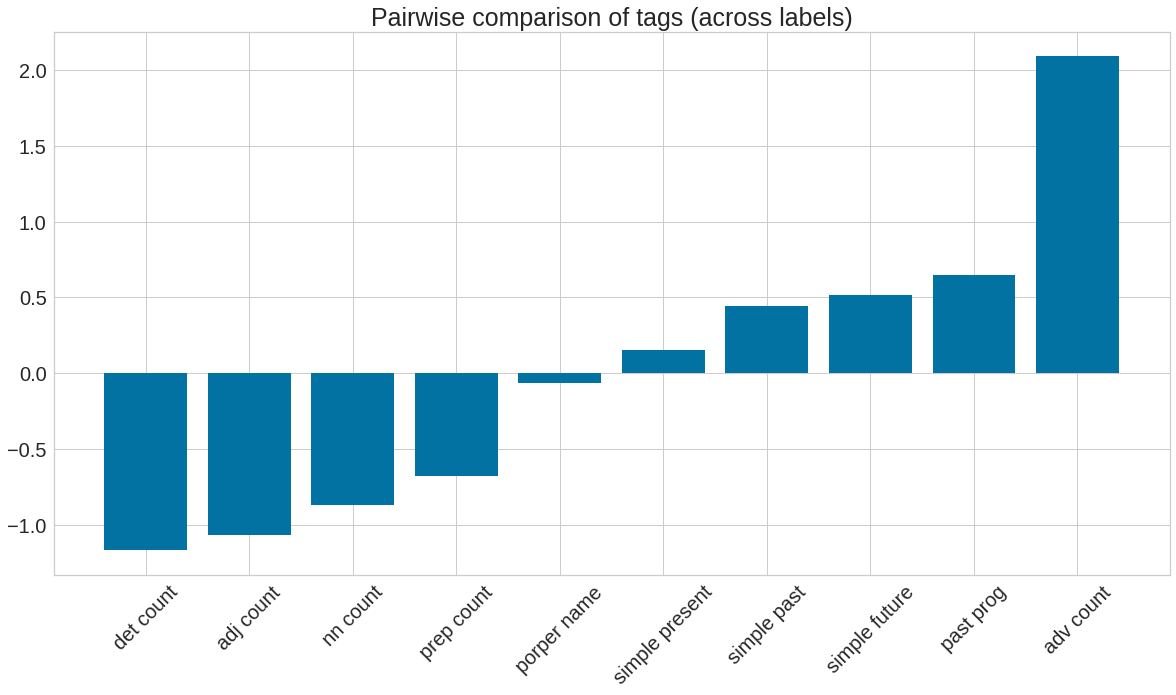

In [293]:
# ins = np.arange(10)
# plt.figure(figsize=(20,10))
# plt.title('Pairwise comparison of tags (across labels)', fontsize=25)
# plt.bar(ins, pltme.sort_values())
# plt.xticks(ins, ticks, rotation=45, fontsize=20)
# plt.yticks(size=20)



### Saliance function

## Saliance

In [ ]:
def saliance(unigrams, unigram_labels, theta=.50):
    """ saliance(data) takes a dataframe and returns a list of dropable variables
    that do not meet a salience theta
    """
    unigrams = pd.concat([unigrams.reset_index(drop=True), unigram_labels], axis=1)
    unigrams_l = unigrams.query('label == "local"')
    unigrams_r = unigrams.query('label == "remote"')

    drop_words = []
    
    for word in unigrams.drop('label', axis = 1):
        normalizer = len([x for x in unigrams[word] if x > 0])
        l_prob_sum = len([x for x in unigrams_l[word] if x > 0]) / normalizer
        r_prob_sum =  len([x for x in unigrams_r[word] if x > 0]) / normalizer
        min_ = min(r_prob_sum, l_prob_sum)
        max_ = max(r_prob_sum, l_prob_sum)
        if max_ != 0:
            salience = (1 - (min_/max_))
        else:
            salience = 0
        if salience == 1 or salience < theta:
    return drop_words

In [314]:
def saliance(words, local_words, remote_words, theta=.50):
    """ saliance(data) takes a dataframe and returns a list of variables to keep
    that meet a salience theta
    """
    keep_words = []
    for i in range(words.shape[1]):
        normalizer = words[:, i].sum()
        l_prob_sum = local_words[:, i].sum() / normalizer
        r_prob_sum = remote_words[:, i].sum() / normalizer

        min_ = min(r_prob_sum, l_prob_sum)
        max_ = max(r_prob_sum, l_prob_sum)
        if max_ != 0:
                salience = (1 - (min_ / max_))
        else:
                salience = 0
        if salience > theta:
            if max_ == l_prob_sum:
                keep_words.append((i, salience, 'local'))
            else:
                keep_words.append((i, salience, 'remote'))
    return keep_words

In [326]:
unigram_vect = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    tokenizer=None,
    preprocessor=None,
    ngram_range=(2,2),
    stop_words=None,
    max_features=1000)

yelp_df = yelp_df.rename(columns={'cool': 'cool_', 'label': 'label_', 'funny': 'funny_', 'useful': 'useful_'})

unigram_fit = unigram_vect.fit_transform(yelp_df['review_text'])

unigrams = pd.DataFrame(
     unigram_fit.A, columns=unigram_vect.get_feature_names())

unigrams = pd.concat([
    unigrams.reset_index(drop=True), 
    yelp_df[['label_']]], axis=1)

sali = unigrams.groupby('label_').agg(
    lambda x: sum(x > 1)).apply(
    lambda x: 1 - (min(x)/max(x)) if max(x) != 0 else 0)
sali_type = unigrams.groupby('label_').agg(
    lambda x: sum(x > 1)).apply(
    lambda x: 'local' if x[0] > x[1] else 'remote')

In [ ]:
had some	0.666667	remote
here on	0.666667	local
if the	0.714286	local
in nyc	0.807692	remote

In [340]:
x[0].sort_values(ascending=False)

TypeError: sort_values() missing 1 required positional argument: 'by'

In [344]:
sali_type = unigrams.groupby('label_').agg(
    lambda x: sum(x > 1)).apply(
    lambda x: 'local' if x[0] > x[1] else 'remote')
x = pd.DataFrame(sali[sali > .65])
x['label'] = sali_type[sali > .65]
x.sort_values(by=0, ascending=False)

,0,label
good service,1.000000,local
very attentive,1.000000,local
dinner and,1.000000,local
was friendly,1.000000,remote
and attentive,1.000000,local
times and,1.000000,local
place has,1.000000,local
and friendly,1.000000,local
back here,1.000000,remote
you to,0.900000,local


In [320]:
sali_type = unigrams.groupby('label_').agg(
    lambda x: sum(x > 1)).apply(
    lambda x: 'local' if x[0] > x[1] else 'remote')

In [321]:
sali_type

10             local
11             local
12             local
15            remote
20             local
25             local
30             local
40             local
45            remote
50             local
able           local
about          local
above         remote
absolutely    remote
across         local
actually       local
add            local
added          local
after          local
afternoon     remote
again          local
ago            local
al             local
all            local
almost         local
along         remote
already        local
also           local
although      remote
always         local
               ...  
wife          remote
will           local
wine           local
wings          local
wish          remote
with           local
within         local
without       remote
won            local
wonderful     remote
work           local
working        local
world         remote
worst         remote
worth         remote
would          local
wouldn       

## Sample from Date Frame

In [79]:
yelp_df = pd.read_csv('all_reviews_cleaned.csv')

In [345]:
yelp_df = yelp_df.rename(columns={'cool': 'cool_', 'label': 'label_', 'funny': 'funny_', 'useful': 'useful_'})

state_min = min(yelp_df.query('business_state != "NJ"').groupby('business_state').agg('count').iloc[:, 0 ])

print(state_min)

sample_ny = yelp_df.query('business_state == "NY"').sample(n=state_min)
sample_nv = yelp_df.query('business_state == "NV"').sample(n=state_min)
sample_ca = yelp_df.query('business_state == "CA"').sample(n=state_min)
sample_fl = yelp_df.query('business_state == "FL"').sample(n=state_min)
sample_il = yelp_df.query('business_state == "IL"').sample(n=state_min)

sample = pd.concat([sample_ny, sample_nv, sample_ca, sample_fl, sample_il]).reset_index(drop = True)

sample_min = min(sample.groupby('label_').agg('count').iloc[:, 0])

print(sample_min)

local_sample = sample.query('label_ == "local"').sample(n=sample_min)
remote_sample = sample.query('label_ == "remote"').sample(n=sample_min)

yelp_df = pd.concat([local_sample, remote_sample]).reset_index(drop = True)

6509
16270


## Clean Data frame

In [346]:
from sklearn.preprocessing import LabelEncoder
le_state = LabelEncoder()
yelp_df[['business_city']] = le_state.fit_transform(yelp_df['business_city'])
le_state = LabelEncoder()
yelp_df[['business_state']] = le_state.fit_transform(yelp_df['business_state'])
le_zip = LabelEncoder()
yelp_df[['business_zip']] = le_zip.fit_transform(yelp_df['business_zip'])
le_loc = LabelEncoder()
yelp_df[['reviewer_location']] = le_loc.fit_transform(yelp_df['reviewer_location'])
le_rstate = LabelEncoder()
yelp_df[['reviewer_state']] = le_rstate.fit_transform(yelp_df['reviewer_state'])

## Train

In [348]:
def saliance(words, local_words, remote_words, theta=.50):
    """ saliance(data) takes a dataframe and returns a list of variables to keep
    that meet a salience theta
    """
    keep_words = []
    for i in range(words.shape[1]):
        normalizer = words[:, i].sum()
        l_prob_sum = local_words[:, i].sum() / normalizer
        r_prob_sum = remote_words[:, i].sum() / normalizer

        min_ = min(r_prob_sum, l_prob_sum)
        max_ = max(r_prob_sum, l_prob_sum)
        if max_ != 0:
                salience = (1 - (min_ / max_))
        else:
                salience = 0
        if salience > theta:
            keep_words.append(i)
    return keep_words


def sampe_data(data):
    state_min = min(data.query('business_state != "NJ"').groupby(
        'business_state').agg('count').iloc[:, 0])

    sample_ny = data.query('business_state == "NY"').sample(n=state_min)
    sample_nv = data.query('business_state == "NV"').sample(n=state_min)
    sample_ca = data.query('business_state == "CA"').sample(n=state_min)
    sample_fl = data.query('business_state == "FL"').sample(n=state_min)
    sample_il = data.query('business_state == "IL"').sample(n=state_min)

    sample = pd.concat(
        [sample_ny, sample_nv, sample_ca,
            sample_fl, sample_il]).reset_index(drop=True)

    sample_min = min(sample.groupby('label_').agg('count').iloc[:, 0])

    local_sample = sample.query('label_ == "local"').sample(n=sample_min)
    remote_sample = sample.query('label_ == "remote"').sample(n=sample_min)

    return pd.concat([local_sample, remote_sample]).reset_index(drop=True)


def label_encoding(data, variables):
    for variable in variables:
        le = LabelEncoder()
        data[[variable]] = le.fit_transform(yelp_df[variable])


yelp_df = add_basic_features()
yelp_df = yelp_df.rename(
    columns={'cool': 'cool_', 'label': 'label_',
             'funny': 'funny_', 'useful': 'useful_'})

yelp_df = add_pos_features(yelp_df)
label_encoding(yelp_df, [
    'reviewer_location',
    'business_zip', 'business_state', 'business_city'])

X = yelp_df.drop([
    'business_city', 'business_state',
    'business_name', 'business_url', 'review_date',
    'reviewer_id'], axis=1)

y = yelp_df[['label_']].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

unigram_vect = CountVectorizer(
    analyzer="word",
    tokenizer=None,
    ngram_range=(2,2),
    preprocessor=None,
    stop_words=None,
    max_features=5000)

unigram_fit = unigram_vect.fit_transform(X_train['review_text'])
unigram_transform = unigram_vect.transform(X_test['review_text'])

local_words = unigram_vect.transform(
    X_train.query('label_ == "local"')['review_text'])
remote_words = unigram_vect.transform(
    X_train.query('label_ == "remote"')['review_text'])
keep_index = saliance(unigram_fit, local_words, remote_words, theta=.65)

unigram_transform = csr_matrix(unigram_transform[:, keep_index])
unigram_fit = csr_matrix(unigram_fit[:, keep_index])
keep_words = np.array(unigram_vect.get_feature_names())[keep_index]

unigram_train = pd.DataFrame(unigram_fit.A, columns=keep_words)

unigram_test = pd.DataFrame(unigram_transform.A, columns=keep_words)

print(unigram_train.shape[1], " n-grams in model")

X_train = X_train.drop(['review_text', 'label_'], axis='columns')
X_train = X_train.join(
    unigram_train, on=None, how='left', lsuffix='',
    rsuffix='', sort=False).fillna(0)

X_test = X_test.drop(['review_text', 'label_'], axis='columns')
X_test = X_test.join(
    unigram_test, on=None, how='left', lsuffix='',
    rsuffix='', sort=False).fillna(0)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())

# logistic_lib = LogisticRegression(solver='liblinear')
# logistic_lbf = LogisticRegression(solver='lbfgs')
# logistic_newton = LogisticRegression(solver='newton-cg')

# logistic_lib.fit(X_train, y_train.values.ravel())
# logistic_lbf.fit(X_train, y_train.values.ravel())
# logistic_newton.fit(X_train, y_train.values.ravel())

logistic_saga = LogisticRegression(solver='saga')
logistic_saga.fit(X_train, y_train.values.ravel())

score_lr = logistic_saga.score(X_test, y_test)
score_nb = gnb.score(X_test, y_test)
print(
    'Logistical regression:', score_lr,
    'Naive bayes: ', score_nb)


NameError: name 'add_basic_features' is not defined

In [14]:
X = yelp_df.drop(['business_city', 'business_state', 'business_name','business_url',
                  'review_date','reviewer_id'], axis = 1)

# X = yelp_df[['business_star_rating', 'business_zip', 'cool_', 
#          'funny_', 'review_raiting', 'useful_', 'review_length', 
#          'week_of_year', 'city_mentioned', 'adv count', 'past prog', 
#          'simple past', 'porper name', 'prep count', 'review_text', 'label' ]]

y = yelp_df[['label']].astype('category')

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, train_size=0.75, test_size=0.25)

unigram_vect = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    tokenizer=None,
    preprocessor=None,
    stop_words=None,
    max_features=1000)

unigram_fit = unigram_vect.fit_transform(X_train['review_text'])
unigram_transform = unigram_vect.transform(X_test['review_text'])


# def saliance(words, local_words, remote_words, theta=.50):
#     drop_words = []
#     for i in range(words.shape[1]):
#         normalizer = words[:, i].sum()
#         l_prob_sum = local_words[:, i].sum() / normalizer
#         r_prob_sum = remote_words[:, i].sum() / normalizer

#         min_ = min(r_prob_sum, l_prob_sum)
#         max_ = max(r_prob_sum, l_prob_sum)
#         if max_ != 0:
#                 salience = (1 - (min_/max_))
#         else:
#                 salience = 0
#         if salience < theta:
#             drop_words.append(i)
#     return drop_words


print(np.array(unigram_vect.get_feature_names())[[100,4,900]])


# unigram_train = pd.DataFrame(
#      unigram_fit.A, columns=unigram_vect.get_feature_names())

# unigram_test = pd.DataFrame(
#      unigram_transform.A, columns=unigram_vect.get_feature_names())

# local_words = unigram_vect.transform(X_train.query('label == "local"')['review_text'])
# remote_words = unigram_vect.transform(X_train.query('label == "remote"')['review_text'])
# drop_index = saliance(unigram_fit, local_words, remote_words, theta=.65)
# drop_words = unigram_train.columns[drop_index]

# unigram_labels = y_train
# drop_words = saliance(unigram_train, unigram_labels, theta=.65)

# unigram_train.drop(drop_words, axis=1, inplace=True)
# unigram_test.drop(drop_words, axis=1, inplace=True)

# print(unigram_train.shape[1], " n-grams in model")

# X_train = X_train.drop(['review_text', 'label'], axis='columns')
# X_train = X_train.join(unigram_train,
#     on=None, how='left', lsuffix='', rsuffix='', sort=False)

# X_test = X_test.drop(['review_text', 'label'], axis='columns')
# X_test = X_test.join(unigram_test,
#     on=None, how='left', lsuffix='', rsuffix='', sort=False)

# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)

['blue' '15' 'try']


In [20]:
import scipy
scipy.sparse.csr.csr_matrix(unigram_fit)[:,[1,2,3]].A

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 0, 1],
       [0, 0, 0],
       [0, 0, 0]], dtype=int64)

In [ ]:
#LassoLarsIC

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic_fit = logistic.fit(X_train, y_train)
y_pred = logistic_fit.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

logistic.score(X_test, y_test)

In [ ]:
dec = []
num = len(y_pred)
correct = np.array(y_test['label'] == y_pred)
for i in range(1,num):
    dec.append((i/len(correct), sum(correct[:i]/i)))

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*dec[0:-1:100]), dashes=[3, 3])
plt.title('Word Frequency by Frequency Rank', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xlabel('Decision', fontsize=25)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

In [ ]:
svm = sklearn.svm.LinearSVC()
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

<Figure size 432x288 with 0 Axes>

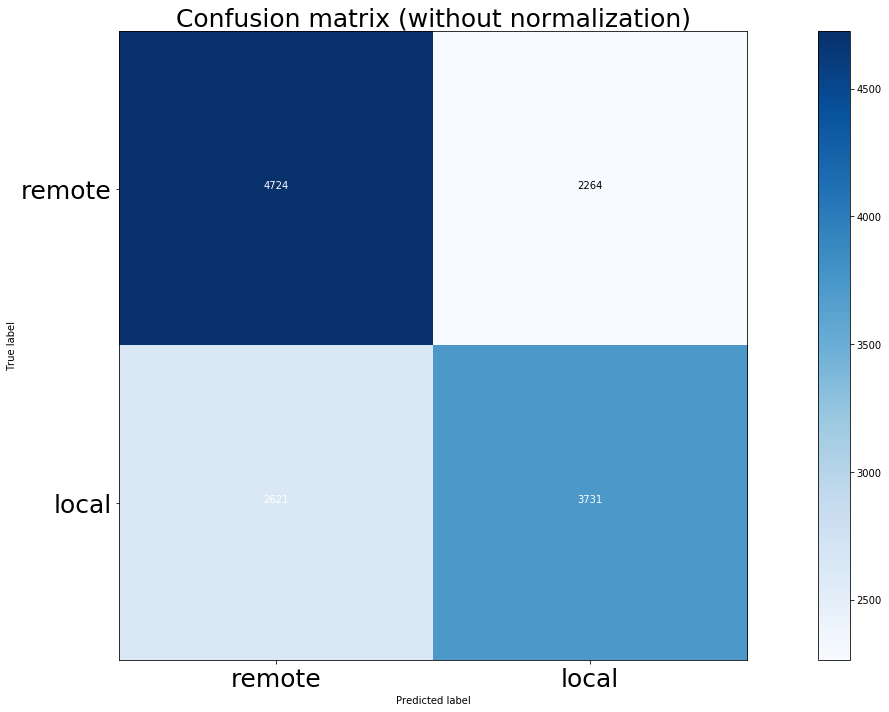

<Figure size 432x288 with 0 Axes>

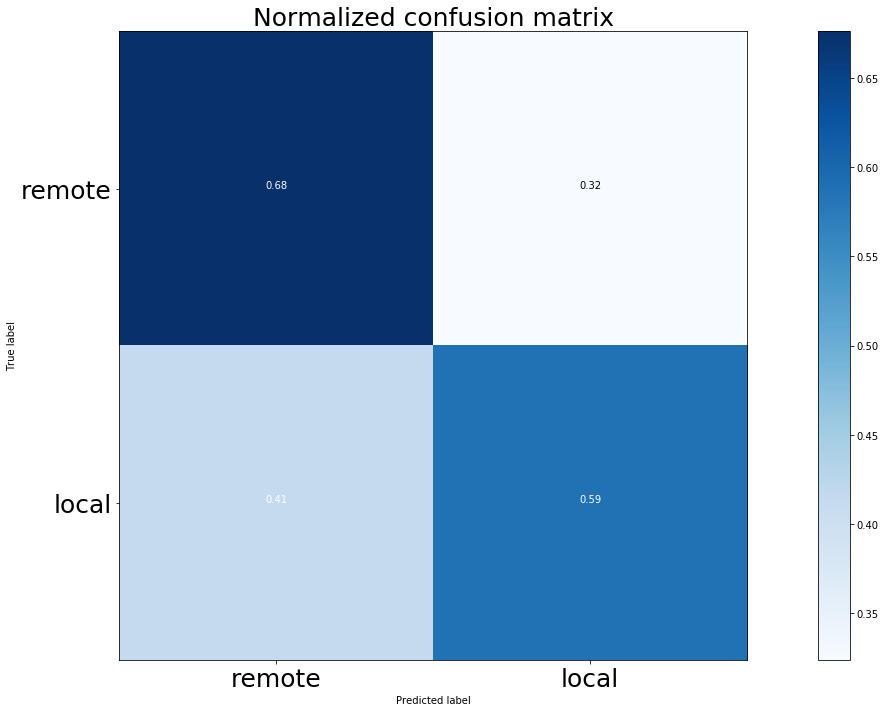

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=25)
    plt.yticks(tick_marks, classes, fontsize=25)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = np.array(['remote', 'local'])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix (without normalization)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [8]:
import features_basic
from features_pos import pos_counter, get_pos_pickle

import numpy as np
import pandas as pd

from scipy.sparse.csr import csr_matrix
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC


def add_basic_features():
    """
    add_basic_features(data) takes a datafram with
    review labels as first column as an input and
    tputs an extended dataframe with features based
    on the Yelp reviews meta data.
    """
    data = pd.read_csv('data/all_reviews_cleaned.csv')

    # Add features
    data = features_basic.review_len(data, 'review_text')

    # week of year
    data = features_basic.week_of_year(data, 'review_date')

    # day of week
    data = features_basic.day_of_week(data, 'review_date')

    # city mentioned
    data = features_basic.city_mentioned(
        data, 'business_city', 'review_text')

    return data


def add_pos_features(data):
    """
    add_pos_features(data) takes a dataframe
    as an input and outputs an exteded dataframe
    with part of speech features added using SPOT.
    """
    reviews_tagged = get_pos_pickle(
        'dump/scraped_reviews_tagged.p')

    data["adv count"] = [
        pos_counter.count_pos(review, pos_counter.adverbs)
        for review in reviews_tagged]

    data["past prog"] = [
        pos_counter.count_pos(review, pos_counter.past_participle)
        for review in reviews_tagged]

    data["simple future"] = [
        pos_counter.count_pos(review, pos_counter.modal)
        for review in reviews_tagged]

    data["simple past"] = [
        pos_counter.count_pos(review, pos_counter.simple_past)
        for review in reviews_tagged]

    data["simple present"] = [
        pos_counter.count_pos(review, pos_counter.simple_present)
        for review in reviews_tagged]

    data['porper name'] = [
        pos_counter.count_pos(review, pos_counter.pn)
        for review in reviews_tagged]

    data['prep count'] = [
        pos_counter.count_pos(review, pos_counter.prep)
        for review in reviews_tagged]

    data['nn count'] = [
        pos_counter.count_pos(review, pos_counter.nn)
        for review in reviews_tagged]

    data['adj count'] = [
        pos_counter.count_pos(review, pos_counter.adj)
        for review in reviews_tagged]

    data['det count'] = [
        pos_counter.count_pos(review, pos_counter.dt)
        for review in reviews_tagged]

    return data


def saliance(words, local_words, remote_words, theta=.50):
    """ saliance(data) takes a dataframe and returns a list of variables to keep
    that meet a salience theta
    """
    keep_words = []
    for i in range(words.shape[1]):
        normalizer = words[:, i].sum()
        l_prob_sum = local_words[:, i].sum() / normalizer
        r_prob_sum = remote_words[:, i].sum() / normalizer

        min_ = min(r_prob_sum, l_prob_sum)
        max_ = max(r_prob_sum, l_prob_sum)
        if max_ != 0:
                salience = (1 - (min_ / max_))
        else:
                salience = 0
        if salience > theta:
            keep_words.append(i)
    return keep_words


def sampe_data(data):
    state_min = min(data.query('business_state != "NJ"').groupby(
        'business_state').agg('count').iloc[:, 0])

    sample_ny = data.query('business_state == "NY"').sample(n=state_min)
    sample_nv = data.query('business_state == "NV"').sample(n=state_min)
    sample_ca = data.query('business_state == "CA"').sample(n=state_min)
    sample_fl = data.query('business_state == "FL"').sample(n=state_min)
    sample_il = data.query('business_state == "IL"').sample(n=state_min)

    sample = pd.concat(
        [sample_ny, sample_nv, sample_ca,
            sample_fl, sample_il]).reset_index(drop=True)

    sample_min = min(sample.groupby('label_').agg('count').iloc[:, 0])

    local_sample = sample.query('label_ == "local"').sample(n=sample_min)
    remote_sample = sample.query('label_ == "remote"').sample(n=sample_min)

    return pd.concat([local_sample, remote_sample]).reset_index(drop=True)


def label_encoding(data, variables):
    for variable in variables:
        le = LabelEncoder()
        data[[variable]] = le.fit_transform(yelp_df[variable])


yelp_df = add_basic_features()
yelp_df = yelp_df.rename(
    columns={'cool': 'cool_', 'label': 'label_',
             'funny': 'funny_', 'useful': 'useful_'})

yelp_df = add_pos_features(yelp_df)
label_encoding(yelp_df, [
    'reviewer_location',
    'business_zip', 'business_state', 'business_city'])

X = yelp_df.drop([
    'business_city', 'business_state',
    'business_name', 'business_url', 'review_date',
    'reviewer_id'], axis=1)

y = yelp_df[['label_']].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

unigram_vect = CountVectorizer(
    analyzer="word",
    tokenizer=None,
    ngram_range=(1,2),
    preprocessor=None,
    stop_words=None,
    max_features=1000)

unigram_fit = unigram_vect.fit_transform(X_train['review_text'])
unigram_transform = unigram_vect.transform(X_test['review_text'])

local_words = unigram_vect.transform(
    X_train.query('label_ == "local"')['review_text'])
remote_words = unigram_vect.transform(
    X_train.query('label_ == "remote"')['review_text'])
keep_index = saliance(unigram_fit, local_words, remote_words, theta=.65)

unigram_transform = csr_matrix(unigram_transform[:, keep_index])
unigram_fit = csr_matrix(unigram_fit[:, keep_index])
keep_words = np.array(unigram_vect.get_feature_names())[keep_index]

unigram_train = pd.DataFrame(unigram_fit.A, columns=keep_words)

unigram_test = pd.DataFrame(unigram_transform.A, columns=keep_words)

print(unigram_train.shape[1], " n-grams in model")

X_train = X_train.drop(['review_text', 'label_'], axis='columns')
X_train = X_train.join(
    unigram_train, on=None, how='left', lsuffix='',
    rsuffix='', sort=False).fillna(0)

X_test = X_test.drop(['review_text', 'label_'], axis='columns')
X_test = X_test.join(
    unigram_test, on=None, how='left', lsuffix='',
    rsuffix='', sort=False).fillna(0)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())

# logistic_lib = LogisticRegression(solver='liblinear')
# logistic_lbf = LogisticRegression(solver='lbfgs')
# logistic_newton = LogisticRegression(solver='newton-cg')

# logistic_lib.fit(X_train, y_train.values.ravel())
# logistic_lbf.fit(X_train, y_train.values.ravel())
# logistic_newton.fit(X_train, y_train.values.ravel())

logistic = sklearn.linear_model.LogisticRegression(solver='saga')
logistic_fit = logistic.fit(X_train, y_train.values.ravel())
y_pred = logistic_fit.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

logistic.score(X_test, y_test)

score_lr = logistic.score(X_test, y_test)
score_nb = gnb.score(X_test, y_test)
print(
    'Logistical regression:', score_lr,
    'Naive bayes: ', score_nb)


2  n-grams in model


/home/gavagai/.conda/envs/data_science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/gavagai/.conda/envs/data_science/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/gavagai/.conda/envs/data_science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/gavagai/.conda/envs/data_science/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Logistical regression: 0.633808095952024 Naive bayes:  0.5727136431784108


/home/gavagai/.conda/envs/data_science/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
